# Toy Transformer 
This file has been created to understand the attention/transformer structure and basic method to build transformer in PyTorch.  "

## 0. Preparation - package import

In [1]:
import os
import json
import torch
import random
import cv2
import numpy as np
import torchvision
from pathlib import Path
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt 
import matplotlib

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Dataset and Dataloader
### Train / valid split based on the **folds** argument

In [2]:
data_path = Path("C:/Users/Siyao/Downloads/EndoVis2017Data")
train_path = data_path / "cropped_train"

def get_split(fold):
    """Split train and valid dataset based on the No. of folder"""
    folds = {0: [1, 3],
             1: [2, 5],
             2: [4, 8],
             3: [6, 7]}
    train_path = data_path / 'cropped_train'

    train_file_names = []
    val_file_names = []

    for instrument_id in range(1, 9):
        if instrument_id in folds[fold]:
            val_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))
        else:
            train_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))

    return train_file_names, val_file_names

train_file_names, val_file_names = get_split(0)

### Function to load image or mask

In [3]:
def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

binary_factor = 255
parts_factor = 85
instrument_factor = 32

def load_mask(path, problem_type="instruments", mask_folder="instruments_masks",factor=instrument_factor):
    if problem_type == 'binary':
        mask_folder = 'binary_masks'
        factor = binary_factor
    elif problem_type == 'parts':
        mask_folder = 'parts_masks'
        factor = parts_factor
    elif problem_type == 'instruments':
        factor = instrument_factor
        mask_folder = 'instruments_masks'

    mask = cv2.imread(str(path).replace('images', mask_folder).replace('jpg', 'png'), 0)

    return (mask / factor).astype(np.uint8)

### Dataset for training and validation

In [4]:
class RoboticsDataset(Dataset):
    """Dataset that only loads single frame"""

    def __init__(self, file_names, to_augment=False, transform=None, mode='train', problem_type=None):
        self.file_names = file_names
        self.to_augment = to_augment
        self.transform = transform
        self.mode = mode
        self.problem_type = problem_type

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_file_name = self.file_names[idx]
        image = load_image(img_file_name)
        mask = load_mask(img_file_name, self.problem_type)

        # data = {"image": image, "mask": mask}
        # augmented = self.transform(**data)
        # image, mask = augmented["image"], augmented["mask"]

        # if self.mode == 'train':
        if self.problem_type == 'binary':
            return torch.from_numpy(image), torch.from_numpy(np.expand_dims(mask, 0)).float(), str(img_file_name)
        else:
            return torch.from_numpy(image), torch.from_numpy(mask).long(), str(img_file_name)
        # else:
        #     return torch.from_numpy(image), str(img_file_name)

train_data_single = RoboticsDataset(train_file_names, problem_type="instrument")
valid_data_single = RoboticsDataset(val_file_names, mode='valid')

### Instrument Dataset
1. Mutiple image stacked as data
2. The label used instrument type

In [5]:
### Creating the lists of file name, that starts from tau frames after the first frame
### which avoid the first few frames having no previous frames issue.

tau = 3
train_img_path = [str(i) for i in train_file_names]
train_frame_name = [i for i in train_img_path if int(i[-7:-4])>=tau]
valid_img_path = [str(i) for i in val_file_names] 
valid_frame_name = [i for i in valid_img_path if int(i[-7:-4])>=tau]

In [6]:
## RESIZE IMAGE TO 1/16 RESOLUTION
class InstrumentDataset(Dataset):
    """Dataset that loads multiple frame"""

    def __init__(self, file_names, problem_type="Instrument", tau=3):
        self.file_names = file_names
        self.problem_type = problem_type
        self.tau = tau      # tau is the number of frames should be combiend
        self.transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([256,320]),
                                transforms.ToTensor()
                            ]) 
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        current_frame = self.file_names[idx]
        mask = load_mask(current_frame, self.problem_type)
        mask = self.transform(mask)
        frames_ls = []
        for i in range(tau):
            to_find = "frame"+current_frame[-7:-4]
            to_repl = "frame"+ '%03d' % (int(current_frame[-7:-4])-i)
            frame = current_frame.replace(to_find, to_repl)
            frame_array = load_image(frame)
            frame_tensor = self.transform(frame_array)
            # frame_tensor = torch.from_numpy(frame_tensor)            
            frames_ls.append(frame_tensor)
        frames_stack = torch.stack(frames_ls, 0)
        # permute the tensor from [tau, H, W, C] to [tau, C, H, W]
        # frames_tensor = frames_stack.permute(0,3,1,2) 
        return frames_stack.float(), mask.float(), str(current_frame)

In [7]:
### Traning and validation data with multi-frames input
# The data in 4D tensor (tau, H, W, C), label in 3D tensor ()
training_data_frames = InstrumentDataset(train_frame_name)
valid_data_frames = InstrumentDataset(valid_frame_name)

### Dataloader

In [8]:
batch_size = 1
training_data_loader = Data.DataLoader(training_data_frames, batch_size=batch_size, shuffle=True)
valid_data_loader = Data.DataLoader(valid_data_frames, batch_size=batch_size, shuffle=False)

In [9]:
a,b,c = next(iter(training_data_loader))
print(f"Data shape: {a.shape}")
print(f"Mask shape: {b.shape}")
print(f"Path: {c}")

Data shape: torch.Size([1, 3, 3, 256, 320])
Mask shape: torch.Size([1, 1, 256, 320])
Path: ('C:\\Users\\Siyao\\Downloads\\EndoVis2017Data\\cropped_train\\instrument_dataset_6\\images\\frame099.jpg',)


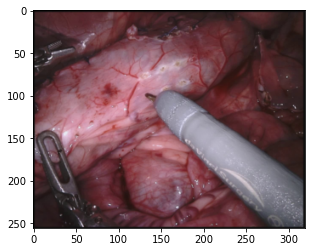

In [15]:
img = a[0][0].permute(1,2,0)
plt.imshow(img)

## Model
### CNN Backbone

In [33]:
# model = models.segmentation.fcn_resnet101(pretrained=True).eval()
model = models.resnet101(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-3])).eval()
# https://stackoverflow.com/questions/61315541/resnet-101-featuremap-shape
model.to(device)
# model.layer4 = nn.Identity
# model.avgpool = nn.Identity()
# model.fc = nn.Identity()
y = model(a[0].to(device))
y.shape

torch.Size([3, 1024, 16, 20])

In [34]:
from torchinfo import summary
summary(model, input_size=(3,3,224, 320))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [3, 64, 112, 160]         9,408
├─BatchNorm2d: 1-2                       [3, 64, 112, 160]         128
├─ReLU: 1-3                              [3, 64, 112, 160]         --
├─MaxPool2d: 1-4                         [3, 64, 56, 80]           --
├─Sequential: 1-5                        [3, 256, 56, 80]          --
│    └─Bottleneck: 2-1                   [3, 256, 56, 80]          --
│    │    └─Conv2d: 3-1                  [3, 64, 56, 80]           4,096
│    │    └─BatchNorm2d: 3-2             [3, 64, 56, 80]           128
│    │    └─ReLU: 3-3                    [3, 64, 56, 80]           --
│    │    └─Conv2d: 3-4                  [3, 64, 56, 80]           36,864
│    │    └─BatchNorm2d: 3-5             [3, 64, 56, 80]           128
│    │    └─ReLU: 3-6                    [3, 64, 56, 80]           --
│ 

In [10]:
class CNNBackbone(nn.Module):
    def __init__(self, model="resnet101", pretrained=True):
        super(CNNBackbone, self).__init__()
        self.model_name = model
        self.pretrained = pretrained
        if self.model_name == "resnet101" and pretrained:
            model = models.resnet101(pretrained=True)
            self.cnn = torch.nn.Sequential(*(list(model.children())[:-3])).eval()
        else:
            raise NotImplementedError("Please use some pretrained CNN models")
        
    
    def forward(self, x):
        y = self.cnn(x[0])
        out = y.unsqueeze(0)
        # out.shape = [batch_size, T, C, H, W] = [1, T, 1024, 16, 20]
        return out

In [12]:
backbone = CNNBackbone().to(device)
y = backbone(a.to(device))

y = y.to("cpu")
y.shape

torch.Size([1, 3, 1024, 16, 20])

### Position Encoding

In [13]:
class PositionalEncoding3D(nn.Module):
    """https://github.com/tatp22/multidim-positional-encoding/blob/master/positional_encodings/positional_encodings.py"""
    
    def __init__(self, channels=1024):
        super(PositionalEncoding3D, self).__init__()
        channels = int(np.ceil(channels/6)*2)
        if channels % 2:
            channels += 1
        self.channels = channels
        inv_freq = 1. / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, tensor):
        # Input tensor shape: [batch_size, T, C, H, W] 
        """
        :param tensor: A 5d tensor of size (batch_size, x, y, z, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, z, ch)
        """
        tensor = tensor.permute(0, 4, 3, 1, 2)
        if len(tensor.shape) != 5:
            raise RuntimeError("The input tensor has to be 5d!")

        batch_size, x, y, z, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        pos_z = torch.arange(z, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        sin_inp_z = torch.einsum("i,j->ij", pos_z, self.inv_freq)
        emb_x = torch.cat((sin_inp_x.sin(), sin_inp_x.cos()), dim=-1).unsqueeze(1).unsqueeze(1)
        emb_y = torch.cat((sin_inp_y.sin(), sin_inp_y.cos()), dim=-1).unsqueeze(1)
        emb_z = torch.cat((sin_inp_z.sin(), sin_inp_z.cos()), dim=-1)
        emb = torch.zeros((x,y,z,self.channels*3),device=tensor.device).type(tensor.type())
        emb[:,:,:,:self.channels] = emb_x
        emb[:,:,:,self.channels:2*self.channels] = emb_y
        emb[:,:,:,2*self.channels:] = emb_z
        out = emb[None,:,:,:,:orig_ch].repeat(batch_size, 1, 1, 1, 1)
        out = out.permute(0, 3, 4, 2, 1)
        return out

In [86]:
pe = PositionalEncoding3D(1024)
z = pe(y)
z.shape

torch.Size([1, 3, 1024, 16, 20])

In [92]:
m = z.permute(0, 2, 3, 4, 1)
# Flatten HWT axies to: [batch_size, channel, HxWxT]
# m = torch.flatten(m, start_dim=2)
# m = torch.squeeze(m, 0)
m = m.flatten(2).squeeze(0)
m.shape

torch.Size([1024, 960])

In [104]:
in_dim = 1024
head = 16
head_dim = in_dim // head
query_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
m = query_conv(z.permute(0, 2, 3, 4, 1))
b, C, H, W, T = m.shape

In [112]:
query_H = m.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H).permute(0,2,1)   # [H,W,T,Dim]
# query_W = m.permute(0,2,1,3,4).contiguous().view(20,-1,16,3)    # [W,H,T,Dim]
# query_T = m.permute(0,4,1,2,3).contiguous().view(3,-1,16,20)
query_H.shape

torch.Size([60, 16, 128])

### Attention

In [187]:
class SparseAttention(nn.Module):
    """Sparse Self Attention Module"""
    def __init__(self, in_dim=1024):
        """The only iuput attribute is dimension"""
        super(SparseAttention, self).__init__()
        self.query_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=4)
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        # Input tensor shape: [batch_size, T, channel, H, W] 
        # Permute x to : [batch_size, channel, H, W, T]
        x = x.permute(0, 2, 3, 4, 1)
        b, C, H, W, T = x.shape
        proj_query = self.query_conv(x)
        proj_query_H = proj_query.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H).permute(0,2,1) # [b*W*T,H,C]
        proj_query_W = proj_query.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W).permute(0,2,1) # [b*H*T,W,C]
        proj_query_T = proj_query.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T).permute(0,2,1) # [b*W*H,T,C]

        proj_key = self.key_conv(x)
        proj_key_H = proj_key.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H)      # [b*W*T,C,H]
        proj_key_W = proj_key.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W)      # [b*H*T,C,W]
        proj_key_T = proj_key.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T)      # [b*W*H,C,T]

        proj_value = self.value_conv(x)
        proj_value_H = proj_value.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H)      # [b*W*T,C,H]
        proj_value_W = proj_value.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W)      # [b*H*T,C,W]
        proj_value_T = proj_value.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T)      # [b*W*H,C,T]

        energy_H = torch.bmm(proj_query_H, proj_key_H).view(b,W,T,H,H).permute(0,3,1,2,4) # [b,H,W,T,H]
        energy_W = torch.bmm(proj_query_W, proj_key_W).view(b,H,T,W,W).permute(0,1,3,2,4) # [b,H,W,T,W]
        energy_T = torch.bmm(proj_query_T, proj_key_T).view(b,H,W,T,T)                    # [b,H,W,T,T]
        score = self.softmax(torch.cat([energy_H,energy_W,energy_T],4))         # [b,H,W,T,(H+W+T)]
        
        att_H = score[:,:,:,:,0:H].permute(0,2,3,1,4).contiguous().view(b*W*T,H,H)      # [b*W*T,H,H]
        att_W = score[:,:,:,:,H:H+W].permute(0,1,4,2,3).contiguous().view(b*H*T,W,W)    # [b*H*T,W,W]
        att_T = score[:,:,:,:,H+W:].contiguous().view(b*H*W,T,T)                        # [b*H*W,T,T]

        out_H = torch.bmm(proj_value_H, att_H.permute(0,2,1)).view(b,W,T,-1,H).permute(0,3,4,1,2)
        out_W = torch.bmm(proj_value_W, att_W.permute(0,2,1)).view(b,H,T,-1,W).permute(0,3,1,4,2)
        out_T = torch.bmm(proj_value_T, att_T.permute(0,2,1)).view(b,H,W,-1,T).permute(0,3,1,2,4)
        
        # permute back to [batch_size, T, channel, H, W] 
        output = self.gamma*(out_H + out_T + out_W).permute(0,4,1,2,3)

        return output

In [192]:
SA = SparseAttention()
output = SA(z)
output.shape, z.shape

(torch.Size([1, 3, 1024, 16, 20]), torch.Size([1, 3, 1024, 16, 20]))

In [193]:
norm = nn.LayerNorm(1024)
output = norm(output.permute(0,3,4,1,2))
output.shape

torch.Size([1, 16, 20, 3, 1024])

In [196]:
fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=1024*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024*2, out_features=1024)
        )
y3 = fc(output)
y3.shape

torch.Size([1, 16, 20, 3, 1024])

In [181]:
gamma = nn.Parameter(torch.zeros(1))
output = gamma*(out_T+out_H+out_W)
output.shape

torch.Size([1, 128, 16, 20, 3])

In [22]:
class SSTEncoder(nn.Module):
    """Define the Multi-head attention -> Add&Norm -> Feed Forward -> Add&Norm module"""
    def __init__(self, dim=1024, dropout=0.2):
        super.__init__()

        # Multi-head attention sub-layer
        self.attn = SparseAttention(dim)
        self.norm_1 = nn.LayerNorm(dim)
        
        # Feed forward sub-layer
        self.fc = nn.Sequential(
            nn.Linear(in_features=dim, out_features=dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=dim*2, out_features=dim)
        )
        self.norm_2 =  nn.LayerNorm(dim)
    
    def forward(self, x):
        y1 = self.attn(x)
        x2 = (x+y1).permute(0,3,4,1,2)   # permute from [b,T,C,H,W] to [b,H,W,T,C]
        y2 = self.norm(x2)
        y3 = self.fc
    
        return out
        

SyntaxError: non-default argument follows default argument (<ipython-input-22-bf556f944f40>, line 3)

## Model

In [22]:
class MyTransformer(nn.Module):
    def __init__(self):
        super(MyTransformer, self).__init__()

        self.backbone = CNNBackbone()
        self.pos_encoding = PositionalEncoding3D()
        

    def forward(self, x):
        # Step 1: subtract feature embedding from CNN backbone
        y1 = self.backbone(x)
        # Step 2: Get positional encoding and add it to the feature embedding
        pe = self.pos_encoding(y1)
        y2 = pe + y1
        return y2

In [23]:
model = MyTransformer()
model = model.to(device)
b = model(a.to(device))

In [24]:
b.shape

torch.Size([1, 3, 1024, 16, 20])

In [25]:
b.squeeze(0).shape

torch.Size([3, 1024, 16, 20])

In [26]:
b.transpose(0,1).resize(1024,960)
b.shape

C:\ProgramData\Anaconda3\envs\datasci\lib\site-packages\torch\tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([1, 3, 1024, 16, 20])